#  Housing Rent Prediction

## Introduction

In this project, we will predict housing rent from features extracted from geographical data and other data related to housing conditions. Given a feature of a house, we want to know the price (in dollars) per night for the house. We will first fetch data from different data sources, including Airbnb, Yelp, Foursquare via different APIs, and extract useful features from them. We will divide all data into training set, validation set and testing set. We will use training set and validation set to build a predictor using regression model and report its performance on the testing set.

For the purpose of this project, we need to import the following libraries:

In [1]:
# Import numerical tools
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as ss
import math

# Import plotting tools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.core.pylabtools import figsize

## Data Collection

In this section, we will collect around 1000 raw data points for houses in Pittsburgh that we need for feature extraction. We collect data from two aspects - housing conditions and geographical conditions. For housing conditions, we use [Airbnb APIs](http://airbnbapi.org/) to collect the current house listings. For geographical conditions, we use [Yelp API](https://github.com/Yelp/yelp-python) and [Fourquare API](https://developer.foursquare.com/) to collect numbers of related businesses around the houses.

### Part I: Collecting Data On Housing Conditions

We organize the information on housing conditions in Table 1 of Tables and Figures in Appendix.

### Part II: Collecting Data On Geographical Conditions

We organize the information on geographical conditions in Table 2 of Tables and Figures in Appendix.

The code for data collection can be found in <span style="color:red">Appendix: Code for Data Collection</span>.

## Feature Extraction

After collecting all the data from different sources, we need to convert them into numerical forms. Originally, some data fields are already numerical, while others need to be converted into numerical values. To-be-converted data fields and mapping between original values and numerical values:

| **data field** | **type** | **original value (mapped value)** |
|----------------|----------|---------------------|
| room_type_category | categorical | entire_home(0), private_room(1), shared_room(2) |
| instant_bookable | boolean | False(0), True(1) |
| cancellation_policy | categorical | strict(0), moderate(1), flexible(2) |
| bed_type_category | categorical | real_bed(0), futon(1), pull_out_sofa(2), couch(3), airbed(4) |
| property_type | categorical | Bed & Breakfast(0), Apartment(1), Loft(2), Guesthouse(3), House(4), Condominium(5), Townhouse(6), Entire Floor(7) |

## Partition Dataset

Let's start with loading raw features and prices:

In [2]:
import pickle

# Load features
with open('data/all_features.pkl') as handle:
    all_features = pickle.load(handle)

# Load price
with open('data/prices.pkl') as handle:
    prices = np.asarray(pickle.load(handle))

Then we normalize the raw features for each dimension:

In [3]:
from sklearn.preprocessing import normalize

def normalize_features(features):
    """ normalize_features normalizes features for each dimension
        
        Input:
            - features (ndarray)
        Output:
            - normalized features (ndarray)
    """
    return normalize(features, norm='max', axis=0)
    
features = normalize_features(all_features)

At midterm stage, we do not use cross-validation and testing. We simply split the data into training set and validation set with relative ratio 0.75 and 0.25.

In [4]:
# Split constant
TRAIN_PERCENT = 0.75
VALIDATION_PERCENT = 0.25
TEST_PERCENT = 0.0
RANDOM_SEED = 13
TRAIN_CUM = 0.75
VALID_CUM = 1.0
TEST_CUM  = 1.0

def split_data(data, label):
    """ split_data splits data into 3 folds:
        train_data, train_label: TRAIN_PERCENT
        valid_data, valid_label: VALID_PERCENT
        test_data,  test_label:  TEST_PERCENT
        
        Input:
            - data (ndarray): raw features to be split
            - label (ndarray): labels corresponding to raw features
        Output:
            - train_data (ndarray): training raw features
            - valid_data (ndarray): validation raw features
            - test_data  (ndarray): testing raw features
            - train_label (ndarray): training labels
            - valid_label (ndarray): validation labels
            - test_label  (ndarray): testing labels  
    """
    
    # Shuffle
    idx = np.arange(data.shape[0])
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(idx)
    data = data[idx]
    label = label[idx]
    
    # Split data into training, validation, and test set
    num_data = len(data)
    train_data  = data[:int(num_data*TRAIN_CUM)]
    train_label = label[:int(num_data*TRAIN_CUM)]
    valid_data  = data[int(num_data*TRAIN_CUM):int(num_data*VALID_CUM)]
    valid_label = label[int(num_data*TRAIN_CUM):int(num_data*VALID_CUM)]
    test_data   = data[int(num_data*VALID_CUM):]
    test_label  = label[int(num_data*VALID_CUM):]
    
    return train_data, valid_data, test_data, train_label, valid_label, test_label

train_X, valid_X, test_X, train_y_true, valid_y_true, test_y_true = split_data(features, prices)

## Feature Selection

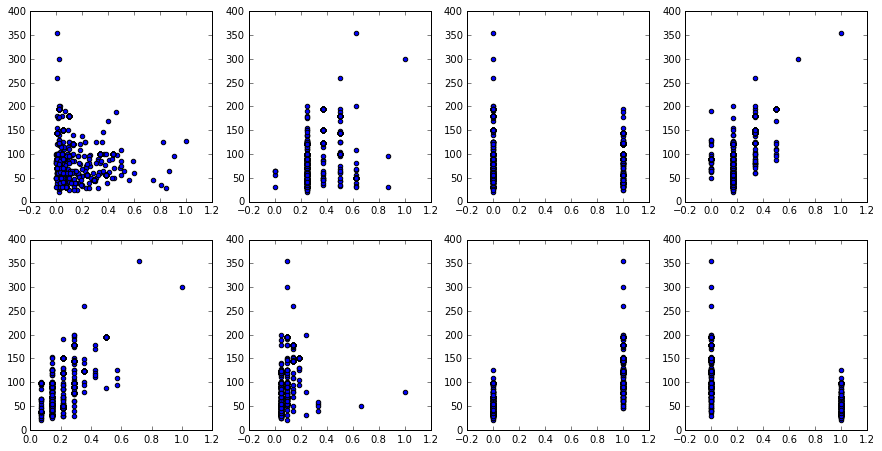

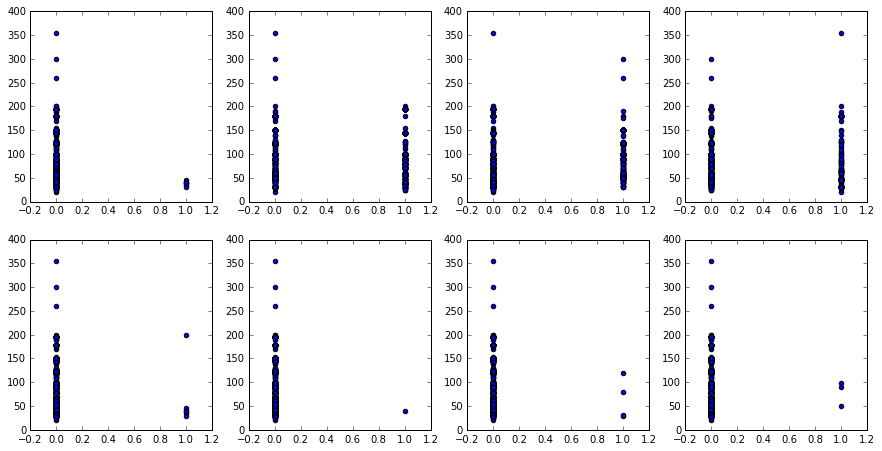

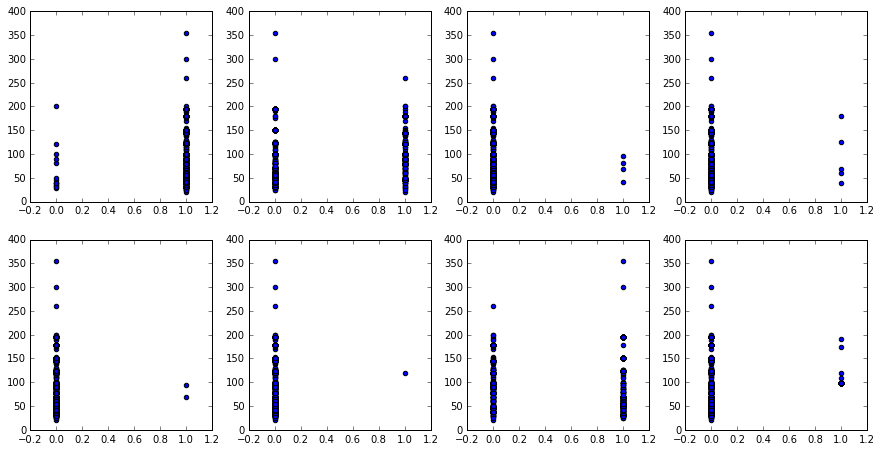

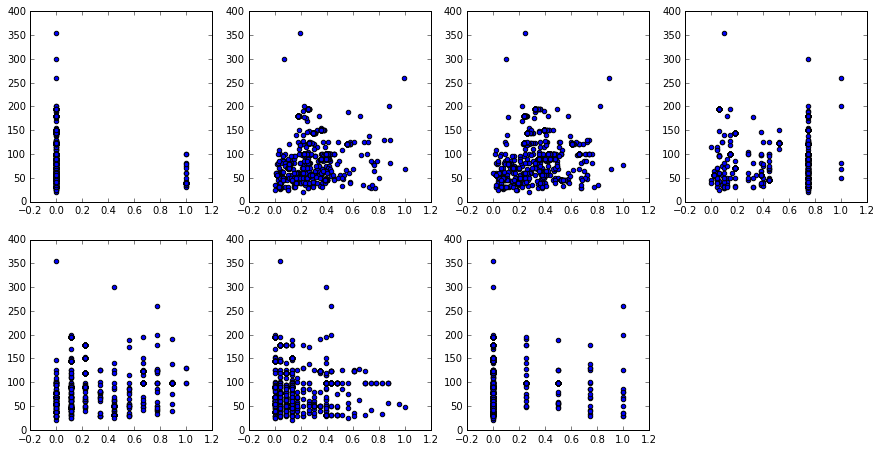

In [5]:
figsize(15, 7.5)

def multi_scatter_plot(X, y):
    """ multi_scatter_plot plots multiple scatter plots,
        each of which is plotted as prices against one
        feature dimension
        
        Input:
            - X (ndarray): features
            - y (ndarray): labels
    """
    fig_nums = min(int((X.shape[1] + 8 - 1) / 8), 40)
    for f in range(fig_nums):
        plt.figure(f+1)
        for i in range(8):
            if i+8*f >= X.shape[1]: break
            num = int('24' + str(i+1))
            plt.subplot(num);
            plt.scatter(X[:,i+8*f], y)  

X = np.concatenate((train_X, valid_X), axis=0)
y = np.concatenate((train_y_true, valid_y_true))

multi_scatter_plot(X, y)

Only a handful of features somewhat correlated to prices. [TODO] Feature selection based on correlation.

## Regression Model

In this section, we explore linear regression and support vector regression model with different kernels.  
[TODO] Brief Intro about support vector regression.  
We will use the following _evaluate_ function to report training and testing performance.

In [6]:
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

MEAN_SQUARED_ERROR = 0
MEAN_ABSOLUTE_ERROR = 1

def evaluate(model, train_X, train_y_true, valid_X, valid_y_true, error_type):
    """ evaluate function train the model and print:
        training mse loss
        validation mse loss
        training R2 coefficient
        validation R2 coefficient
        
        Input:
            - model (model): model to be evaluated
            - train_X (ndarray): training features
            - train_y_true (ndarray): training labels
            - valid_X (ndarray): validation features
            - valid_y_true (ndarray): validation labels
    """
    # fit train data into model
    model.fit(train_X, train_y_true)
    
    # predict
    train_y_pred = model.predict(train_X)
    valid_y_pred = model.predict(valid_X)
    
    print 'Sample Result [(Predict, True)]:', zip(valid_y_pred[:10], valid_y_true[:10])
    # print 'coefficient:', model.coef_

    # Print statistics
    # The error
    if error_type is MEAN_SQUARED_ERROR:
        print("Train set mean squared error: %.4f"
              % mean_squared_error(train_y_true, train_y_pred))
        print("Valid set mean squared error: %.4f"
              % mean_squared_error(valid_y_true, valid_y_pred))
    elif error_type is MEAN_ABSOLUTE_ERROR:
        print("Train set mean absolute error: %.4f"
              % mean_absolute_error(train_y_true, train_y_pred))
        print("Valid set mean absolute error: %.4f"
              % mean_absolute_error(valid_y_true, valid_y_pred))
    
    # R2: 1 is perfect
    print('Train set R2: %.4f' % r2_score(train_y_true, train_y_pred))
    print('Valid set R2: %.4f' % r2_score(valid_y_true, valid_y_pred))

### Linear Regression with Raw Features

First, we experiment with raw features using linear regression model.

In [7]:
linear_regr = linear_model.LinearRegression()
evaluate(linear_regr, train_X, train_y_true, valid_X, valid_y_true, MEAN_SQUARED_ERROR)

Sample Result [(Predict, True)]: [(47.437204693241576, 55.0), (54.925398153406682, 50.0), (114.85838403611487, 80.0), (61.850131193996702, 45.0), (53.819512843258515, 70.0), (96.341407609967987, 90.0), (48.203428506431514, 50.0), (147.72229204909308, 179.0), (149.57245669254422, 145.0), (84.670032810601867, 90.0)]
Train set mean squared error: 309.7073
Valid set mean squared error: 296.6302
Train set R2: 0.8491
Valid set R2: 0.8514


Surprisingly the result looks good - small mean squared error and high $R^2$ coefficient on validation set. In addition, we see that many of the predictions on validation data are close to real ones. Next, we want to see whether support vector regression model could do better on this data set.

### Support Vector Regression with Linear Kernel


In [8]:
svr_linear = SVR(C=10000.0, epsilon=0.2, kernel='linear')
evaluate(svr_linear, train_X, train_y_true, valid_X, valid_y_true, MEAN_ABSOLUTE_ERROR)

Sample Result [(Predict, True)]: [(54.894268647771071, 55.0), (50.208553966305601, 50.0), (123.58313169758168, 80.0), (54.597228454702247, 45.0), (63.200361179165895, 70.0), (89.707437012318962, 90.0), (51.201554056067664, 50.0), (135.28173856627819, 179.0), (145.25733177328749, 145.0), (89.986926802062783, 90.0)]
Train set mean absolute error: 10.1198
Valid set mean absolute error: 9.8161
Train set R2: 0.8247
Valid set R2: 0.8472


SVR with linear kernel gives slightly worse performance than linear regression.

### Support Vector Regression with Polynomial Features

Next, we want to see how well it performs with polynomial kernel with degree 3.

In [9]:
svr_poly = SVR(C=10000.0, epsilon=0.2, kernel='poly', degree=3)
evaluate(svr_poly, train_X, train_y_true, valid_X, valid_y_true, MEAN_ABSOLUTE_ERROR)

Sample Result [(Predict, True)]: [(55.346223329973796, 55.0), (50.035490677647644, 50.0), (79.052196236577856, 80.0), (45.077635253547307, 45.0), (70.675405970027015, 70.0), (89.799930417825735, 90.0), (62.606587365406185, 50.0), (178.73855467933564, 179.0), (144.7065384129495, 145.0), (90.158564097920916, 90.0)]
Train set mean absolute error: 4.5948
Valid set mean absolute error: 5.3339
Train set R2: 0.9270
Valid set R2: 0.9081


This gives quite stunning results. But we need more data to confirm whether this holds in general dataset.

### Support Vector Regression with RBF Kernel

Now we try SVR with RBF kernel.

In [10]:
svr_rbf = SVR(C=1000.0, epsilon=0.2, kernel='rbf')
evaluate(svr_rbf, train_X, train_y_true, valid_X, valid_y_true, MEAN_ABSOLUTE_ERROR)

Sample Result [(Predict, True)]: [(55.346532584015662, 55.0), (50.199602370016336, 50.0), (92.048118676958424, 80.0), (45.015536298577771, 45.0), (70.582822712560855, 70.0), (89.800011593104372, 90.0), (57.120732714858363, 50.0), (178.63258680016042, 179.0), (144.79929262625774, 145.0), (90.174792318409104, 90.0)]
Train set mean absolute error: 5.4356
Valid set mean absolute error: 5.5761
Train set R2: 0.9039
Valid set R2: 0.8965


Slightly worse than polynomial kernel, but still we need more data to confirm.

### Regularization

[TODO] We will explore whether regularization will gives better result.

### Dimensionality Reduction

[TODO] We will explore whether dimensionality reduction will give better result.

## Next Steps

1. Collect more data from different cities.
2. Add other related features: salary, review positivity, number of lisings nearby.
3. Model selection for SVR: C, epsilon, kernel.
4. Try other models as well as cross validation.

##  References

## Appendices

### [Table and Figures](http://nbviewer.jupyter.org/github/jerryzh168/15688-proj/blob/master/Table%20and%20Figures.ipynb)

### Code for Data Collection
1. [Airbnb features](https://www.dropbox.com/s/jitetutoa0rlgrl/airbnb.py?dl=0), the code to collect the data from airbnb, the current listings from a city and all the related features related to housing conditions.
2. [Foursquare features](https://www.dropbox.com/s/2s7s1yerjxm1gn5/foursquare.py?dl=0), the code to collect the geographical feature about number of attractions in a given region.
3. [Income](https://www.dropbox.com/s/xjy5jcc2ij2p6pd/income.py?dl=0), the code to get average salary of a given city.
4. [Transforming the collected data](https://www.dropbox.com/s/yvfh8qasjp54alt/transform.py?dl=0), the code to transform the collected data and store as a numpy array.